<a href="https://www.analytiksinc.com">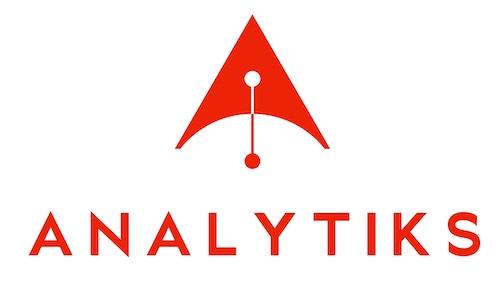</a>
<p style="text-align: right;"> © 2021. Analytiks Inc. </p>

# Time Series Analysis

## Import Libraries

In [43]:
#ignore warnings
import warnings
from matplotlib import pyplot as plt
warnings.filterwarnings('ignore')

### Standard Libraries

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

%matplotlib inline

### Additional Libraries

<a href = 'https://facebook.github.io/prophet/docs/installation.html#python'>FBProphet</a>

In [45]:
#FBProphet
from fbprophet import Prophet

#Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Helper Functions

In [46]:
def forecast_metrics(y_true, y_pred):
    """Calculate MAE, MSE, RMSE, and MAPE of the forecast.
    
       Args:
           y_true: actual results
           y_pred: predicted results
    """
    
    #MAE
    mae = mean_absolute_error(y_true, y_pred)
    
    #MSE
    mse = mean_squared_error(y_true, y_pred)
    
    #RMSE
    rmse = np.sqrt(mse)
    
    #MAPE
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))
    
    print(("MAE: %.2f") % mae)
    print(("MSE: %.2f") % mse)
    print(("RMSE: %.2f") % rmse)
    print(("MAPE: %.2f") % (mape * 100))
    

## Load and Explore the Dataset

Filename: superstore_sales_data.csv

In [47]:
df = pd.read_csv('../Downloads/superstore_sales_data-edited.csv', index_col=0, parse_dates=['Request Date'])

View the Dataset

In [48]:
df.head()

,Order ID,Request Date,Completion Date,Customer ID,Customer Name
Row_ID,,,,,
1,CA-2017-152156,2017-08-11,11/11/2017,CG-12520,Claire Gute
2,CA-2017-152156,2017-08-11,11/11/2017,CG-12520,Claire Gute
3,CA-2017-138688,2017-12-06,16/06/2017,DV-13045,Darrin Van Huff
4,US-2016-108966,2016-11-10,18/10/2016,SO-20335,Sean O'Donnell
5,US-2016-108966,2016-11-10,18/10/2016,SO-20335,Sean O'Donnell


Check Info

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 1 to 9800
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Order ID         9800 non-null   object        
 1   Request Date     9800 non-null   datetime64[ns]
 2   Completion Date  9800 non-null   object        
 3   Customer ID      9800 non-null   object        
 4   Customer Name    9800 non-null   object        
dtypes: datetime64[ns](1), object(4)
memory usage: 459.4+ KB


In [50]:
df.nunique()

Order ID           4922
Request Date       1230
Completion Date    1326
Customer ID         793
Customer Name       793
dtype: int64

Groupby 'Request Date' and get count of 'Completed_requests', convert to Series for easier manipulation

In [51]:
daily = df.groupby('Request Date').agg({'Order ID':['count']})

daily.columns = ['Completed_requests']

daily.head()

,Completed_requests
Request Date,
2015-01-02,1
2015-01-03,10
2015-01-04,4
2015-01-06,11
2015-01-07,3


Check Start and End Date of the Series

In [52]:
print("Start Date: %s | End Date: %s " % (daily.index.min(),daily.index.max()))

Start Date: 2015-01-02 00:00:00 | End Date: 2018-12-30 00:00:00 


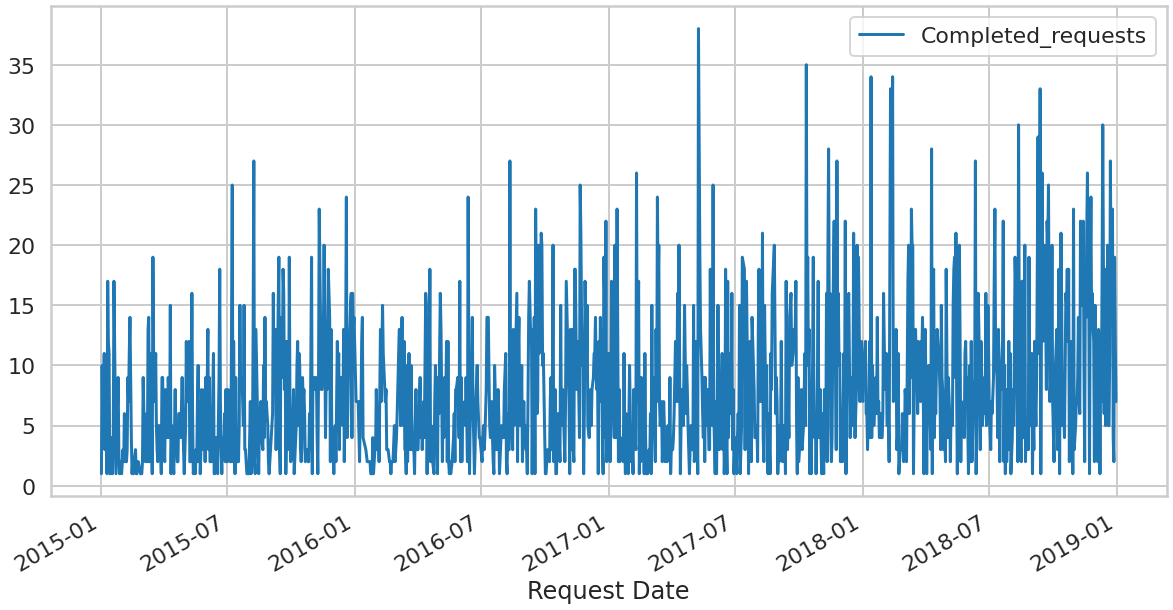

In [54]:
#Plot the Data
daily.plot(kind='line', figsize = (20,10))
plt.savefig('graph/data1.png', bbox_inches='tight')

In [55]:
#Get Monthly Data
monthly = daily.resample('M').apply(sum)

monthly.head()

,Completed_requests
Request Date,
2015-01-31,126
2015-02-28,84
2015-03-31,161
2015-04-30,121
2015-05-31,146


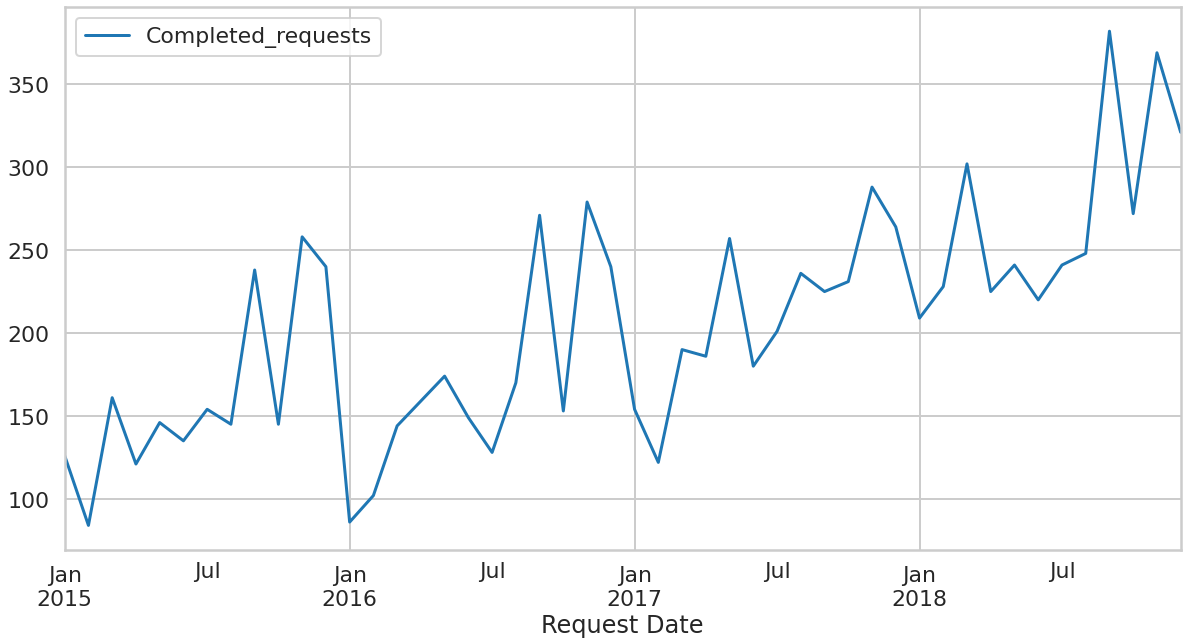

In [56]:
#Plot the Data
monthly.plot(kind='line', figsize = (20,10))
plt.savefig('graph/data2.png', bbox_inches='tight')

## Split into Train and Test

In [57]:
#We'll use the last 12 months for testing, and the remaining months for training

test = monthly[monthly.index.year == 2018]

train = monthly[monthly.index.year < 2018]

In [58]:
train.shape, test.shape

((36, 1), (12, 1))

In [59]:
print("Train: Start Date: %s |  End Date: %s " % (train.index.min(),train.index.max()))
print("Test: Start Date: %s |  End Date: %s " % (test.index.min(),test.index.max()))

Train: Start Date: 2015-01-31 00:00:00 |  End Date: 2017-12-31 00:00:00 
Test: Start Date: 2018-01-31 00:00:00 |  End Date: 2018-12-31 00:00:00 


_____

## FB Prophet

In [60]:
#Convert our dataframe to the format required by Prophet

train_fb = train.reset_index()
train_fb.columns = ['ds','y']

test_fb = test.reset_index()
test_fb.columns = ['ds','y']

train_fb.head()

,ds,y
0,2015-01-31,126
1,2015-02-28,84
2,2015-03-31,161
3,2015-04-30,121
4,2015-05-31,146


In [61]:
#Instantiate the model

model = Prophet(seasonality_mode='multiplicative')

model.fit(train_fb)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [62]:
#Create DataFrame for Forecasts
future = model.make_future_dataframe(periods=12, freq='M')
future

,ds
0,2015-01-31
1,2015-02-28
2,2015-03-31
3,2015-04-30
4,2015-05-31
5,2015-06-30
6,2015-07-31
7,2015-08-31
8,2015-09-30
9,2015-10-31


In [63]:
#Get Forecasts
forecast = model.predict(future)

forecast.tail(n=12)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
36,2018-01-31,210.745725,139.992073,187.512524,210.745725,210.745725,-0.227699,-0.227699,-0.227699,-0.227699,-0.227699,-0.227699,0.0,0.0,0.0,162.759055
37,2018-02-28,212.459098,104.446568,153.176157,212.459097,212.459098,-0.390399,-0.390399,-0.390399,-0.390399,-0.390399,-0.390399,0.0,0.0,0.0,129.515313
38,2018-03-31,214.356046,200.647179,246.616778,214.356046,214.356047,0.041383,0.041383,0.041383,0.041383,0.041383,0.041383,0.0,0.0,0.0,223.226698
39,2018-04-30,216.191803,166.342089,212.732336,216.191803,216.191804,-0.117682,-0.117682,-0.117682,-0.117682,-0.117682,-0.117682,0.0,0.0,0.0,190.749851
40,2018-05-31,218.088752,216.030537,262.019356,218.088751,218.088753,0.097597,0.097597,0.097597,0.097597,0.097597,0.097597,0.0,0.0,0.0,239.373457
41,2018-06-30,219.924509,171.381261,216.540106,219.924508,219.924510,-0.118753,-0.118753,-0.118753,-0.118753,-0.118753,-0.118753,0.0,0.0,0.0,193.807830
42,2018-07-31,221.821457,190.741688,236.425700,221.821456,221.821459,-0.037382,-0.037382,-0.037382,-0.037382,-0.037382,-0.037382,0.0,0.0,0.0,213.529327
43,2018-08-31,223.718406,200.878569,246.781340,223.718404,223.718408,0.000085,0.000085,0.000085,0.000085,0.000085,0.000085,0.0,0.0,0.0,223.737506
44,2018-09-30,225.554163,276.918733,322.760407,225.554161,225.554165,0.335377,0.335377,0.335377,0.335377,0.335377,0.335377,0.0,0.0,0.0,301.199806
45,2018-10-31,227.451112,195.231877,241.249966,227.451109,227.451114,-0.036783,-0.036783,-0.036783,-0.036783,-0.036783,-0.036783,0.0,0.0,0.0,219.084708


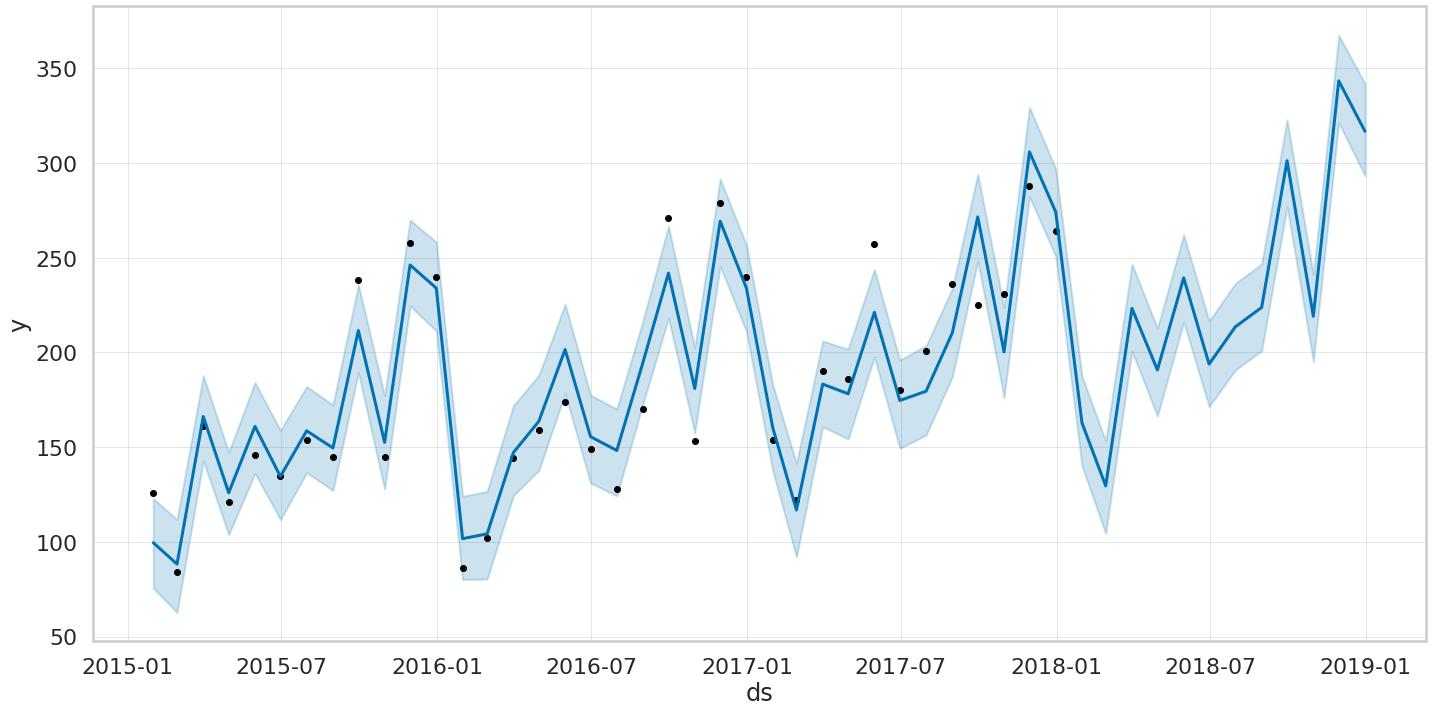

In [64]:
#Plot the Forecast
fig1 = model.plot(forecast, figsize=(20,10))
plt.savefig('graph/forecast3.png', bbox_inches='tight')

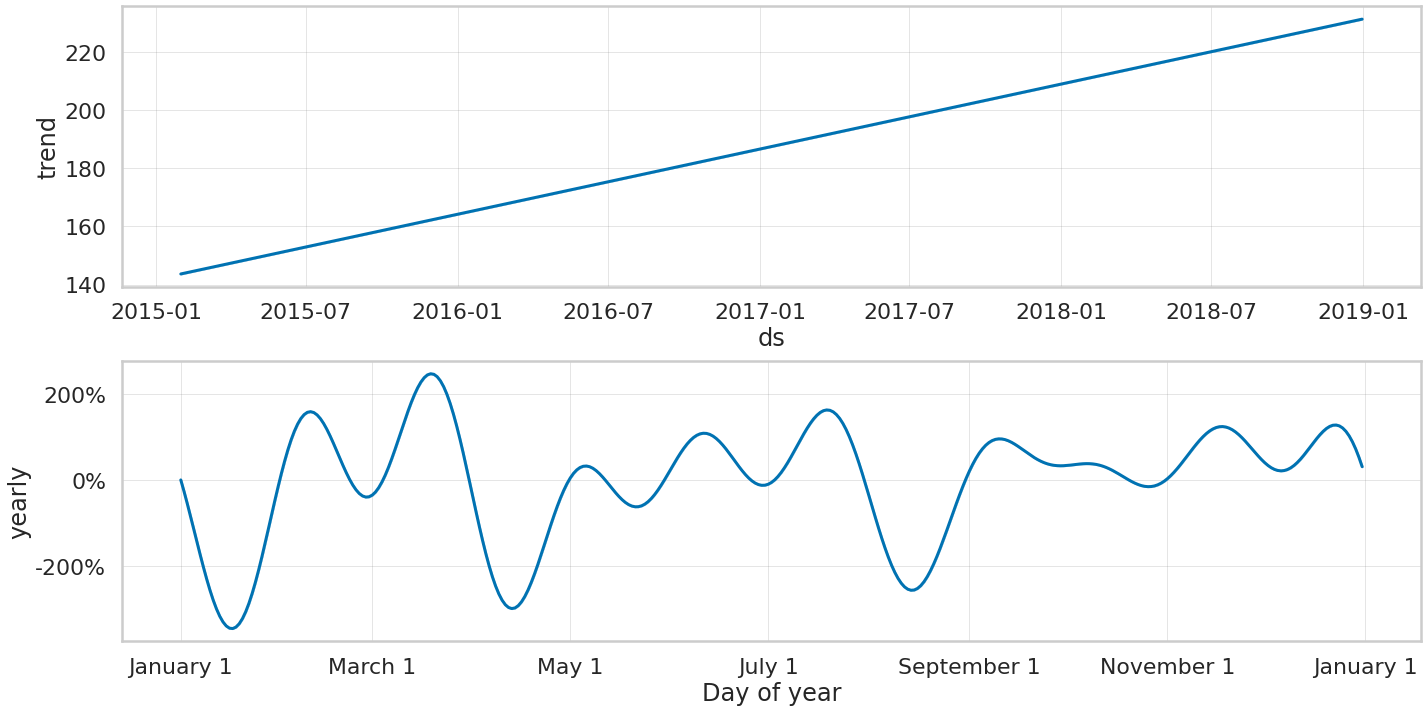

In [65]:
#Plot the Components
fig2 = model.plot_components(forecast, figsize=(20,10))
plt.savefig('graph/components4.png', bbox_inches='tight')

In [66]:
#Join with actual results to get the metrics 
results_df = pd.merge(forecast, monthly, left_on='ds', right_index=True)
results_df = results_df[['ds','Completed_requests','yhat']]
results_df.head()

,ds,Completed_requests,yhat
0,2015-01-31,126,99.520268
1,2015-02-28,84,88.248345
2,2015-03-31,161,166.157061
3,2015-04-30,121,125.900000
4,2015-05-31,146,160.939959


In [67]:
train_results = results_df[(results_df.ds.dt.year < 2018)]
test_results = results_df[(results_df.ds.dt.year == 2018)]

In [68]:
#Train Metrics
forecast_metrics(train_results.Completed_requests,train_results.yhat)

MAE: 14.30
MSE: 332.71
RMSE: 18.24
MAPE: 7.87


In [69]:
forecast_metrics(test_results.Completed_requests,test_results.yhat)

MAE: 41.75
MSE: 2604.36
RMSE: 51.03
MAPE: 15.77


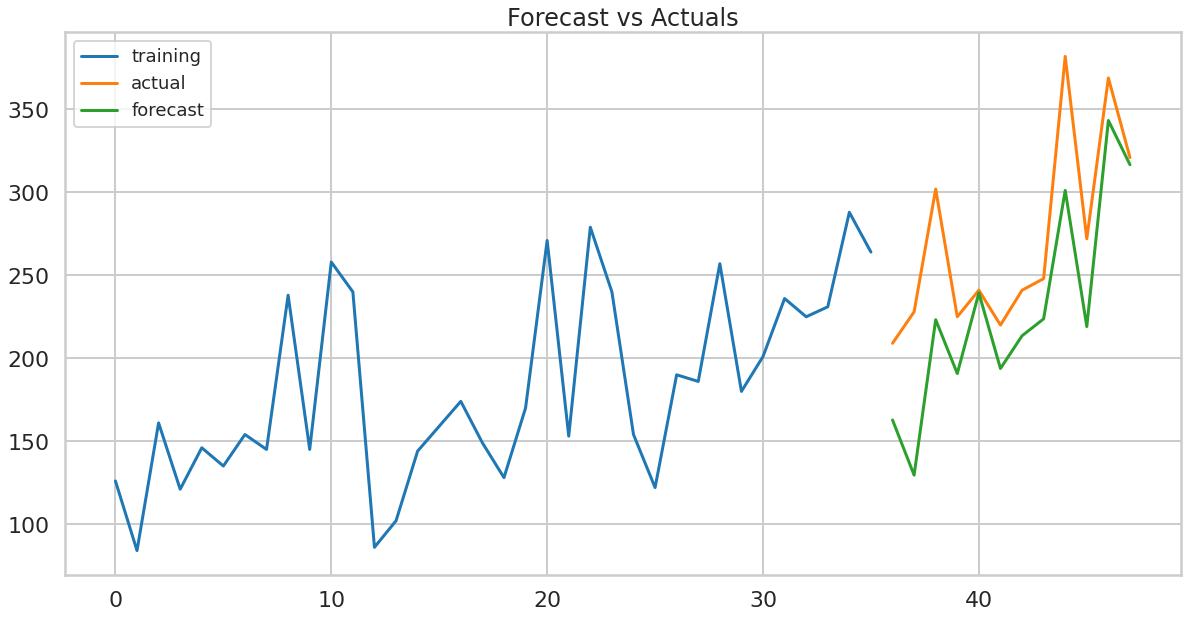

In [70]:
# Plot
plt.figure(figsize=(20,10))
plt.plot(train_results.Completed_requests, label='training')
plt.plot(test_results.Completed_requests, label='actual')
plt.plot(test_results.yhat, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=18)
plt.savefig('graph/ForecastvsActuals5.png', bbox_inches='tight')
plt.show()
